# Finetuning fish dataset (with transfer learning)


This notebook is based on the pytorch tutorial for transfer learning:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network. This can be pretrained on imagenet
   or on our own dataset with SSL pretraining.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained. (this is the fine-tuning step)

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion #interactive mode, show plt's on creation

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

## Loading the data
We will use torchvision and torch.utils.data packages for loading the
data. 
<br><br>
In the code cell below:
- specifying the transforms for the training set
- creating dataset object
- creating dataloader object
- extracting the class names
- setting up the device being used for training [cpu/cuda:0]

In [3]:
#The transformations to apply to the training dataset:
data_transforms = transforms.Compose(
    [
        #transforms.RandomResizedCrop(224),  
        transforms.CenterCrop(224),  #resnet50 typically takes a 224x224 image as input
        transforms.ToTensor()
    ]
)


#Creating the dataset object with the: 
#correct path to the class folders and images in them
#and the specified data_transforms above
data_dir = "E:\MP\datasets\Fish"
image_dataset_train = datasets.ImageFolder(os.path.join(data_dir),data_transforms) 

#Creating the dataloader object for training
dataloader_train = torch.utils.data.DataLoader(image_dataset_train, batch_size=4,shuffle=True, num_workers=2)
dataset_size = len(image_dataset_train)
print(f"Dataset size: {dataset_size}",end="\n\n")

#Extracting the class names with the datasets.ImageFolder.classes method
class_names = image_dataset_train.classes
print(f"class_names: {class_names}", end="\n\n")
#The classes are: [ordered alphabetically]
#The index represents the corresponding output neuron that represent how lickely it classified that fish
# 0 -> 'Black Sea Sprat'
# 1 -> 'Gilt-Head Bream'
# 2 -> 'Hourse Mackerel'
# 3 -> 'Red Mullet' 
# 4 -> 'Red Sea Bream'
# 5 -> 'Sea Bass'
# 6 -> 'Shrimp'
# 7 -> 'Striped Red Mullet'
# 8 -> 'Trout'

#setting the device to the best available (hopefully cuda to train on GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Dataset size: 9000

class_names: ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

Using device cuda:0


### Visualize a couple examples from the Fish dataset
Let's visualize a few training images so as to understand the data
augmentations.

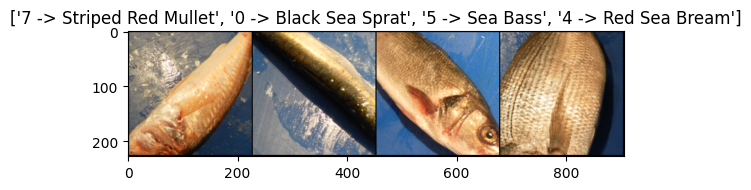

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    #transpose to 2d image with color channels from tensor representation
    inp = inp.numpy().transpose((1, 2, 0))
    
    #if you normalise in the data transforms, unnormalize like this:
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    
    #clip values between 0 and 1
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader_train))

# Make a grid from batch
img_grid = torchvision.utils.make_grid(inputs)

#title = print the label and the class_name corresponding to it
imshow(img_grid, title=[ (str(x.item()) + " -> " + class_names[x]) for x in classes])

### TensorBoard setup
When you finished this notebook and are in tensorboard: <br>
Look at the scalar tab for training loss and accuracy. <br>
Look at the graph tab to see the model graph and dataflow.

In [5]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs_ft/fish_exp1')

# Write image data to TensorBoard log dir
writer.add_image('one batch of fish images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs_ft
# ...and open a browser tab to http://localhost:6006/

## Training
Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

<br>
In the code cell below:

- We define the train function which will be the train loop
- We loop over the specified number of epochs
- In each epoch we loop over the data using the dataloader_train
- We keep the model that had the heighest accuracy

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        
        model.train() #set the model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloader_train:
            #putting data and labels on gpu
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            #torch.max(outputs,1) returns 
            #the max values of the ouput tensor (each image's output in this batch is a row in this tensor) -> ignore values, store to _
            #the index of these max values in the output tensor -> these are the predictions that correspond to class indicis
            _, preds = torch.max(outputs, 1)
            #compare outputs output tensor to label tensor to see how far off the neural net was
            loss = criterion(outputs, labels)
            
            #compute grad
            loss.backward()
            #nudge weights based on grad's calculated +(LR*-grad)
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        ########LOGGING LOSS AND ACCURACY TO TENSORBOARD########
        # Log the running loss averaged per batch
        writer.add_scalars(
            'fish',
            {'Training Loss' : epoch_loss, 'Training Acc' : epoch_acc },
            epoch
        )
        ########################################################

        # deep copy the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()
    ##########################################
    #making sure tensorboard data is written to disk:
    writer.flush()
    ##########################################
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best training Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the predictions

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_train):
            #move data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j].item()} -> {class_names[preds[j]]}\n GT: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Option 1: Finetuning the ConvNet
If you have already fine tuned the model and saved the weights, skip these cells until "Option 2: Load weights from previous fine tuning"
- adjusting the resnet50 architecture to have an fc with len(class_names) output neurons for classification
- loading the weights from pre-training
- moving model to GPU
- setting up criterion, optimizer, and lr decay scheduler


In [8]:
#downloaded models are sace to users/ovanl/.cache/torch/hub/checkpoints/resnet50.path
model_ft = models.resnet50()

#freezing the weights of the convolutional layers by turning of grad, which means the gradient won't be 
#calculated/tracked anymore with autograd
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
print(f"last layer before adjustment {model_ft.fc} ")

#replacing the final fully connected layer from a 2048,1000 -> 2048,len(class_names)
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) #new linear layer has autograd on automatically
print(f"last layer after adjustment {model_ft.fc} ")

#loading the neural network with pretrained weights:
model_ft.load_state_dict( torch.load("resnet50/fish/resnet50_fish_ft.pth"))
print("Resnet50 weights loaded from file ")
#saving the current network parameters to a file
#torch.save(model_ft.state_dict(), "resnet50/fish/resnet50_fish_ft.pth")

#move model to GPU for training on CUDA device
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

last layer before adjustment Linear(in_features=2048, out_features=1000, bias=True) 
last layer after adjustment Linear(in_features=2048, out_features=9, bias=True) 
Resnet50 weights loaded from file 


### Training
fine tune the model and save the weights

In [9]:
#only fine tuning lineair classifier layer
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
#saving the current network parameters to a file
torch.save(model_ft.state_dict(), "resnet50/fish/resnet50_fish_ft_after.pth")

Epoch 0/24
----------
Loss: 0.5749 Acc: 0.8194

Epoch 1/24
----------
Loss: 0.3001 Acc: 0.9031

Epoch 2/24
----------
Loss: 0.2468 Acc: 0.9197

Epoch 3/24
----------
Loss: 0.2194 Acc: 0.9280

Epoch 4/24
----------
Loss: 0.2015 Acc: 0.9350

Epoch 5/24
----------
Loss: 0.2235 Acc: 0.9254

Epoch 6/24
----------
Loss: 0.1793 Acc: 0.9427

Epoch 7/24
----------
Loss: 0.1499 Acc: 0.9520

Epoch 8/24
----------
Loss: 0.1510 Acc: 0.9516

Epoch 9/24
----------
Loss: 0.1559 Acc: 0.9529

Epoch 10/24
----------
Loss: 0.1470 Acc: 0.9541

Epoch 11/24
----------
Loss: 0.1477 Acc: 0.9554

Epoch 12/24
----------
Loss: 0.1643 Acc: 0.9464

Epoch 13/24
----------
Loss: 0.1530 Acc: 0.9537

Epoch 14/24
----------
Loss: 0.1448 Acc: 0.9537

Epoch 15/24
----------
Loss: 0.1461 Acc: 0.9532

Epoch 16/24
----------
Loss: 0.1474 Acc: 0.9548

Epoch 17/24
----------
Loss: 0.1535 Acc: 0.9542

Epoch 18/24
----------
Loss: 0.1412 Acc: 0.9553

Epoch 19/24
----------
Loss: 0.1470 Acc: 0.9544

Epoch 20/24
----------
Loss: 0

##  Option 2: Load weights from previous fine tuning
Only execute the cell below if you have done the finetuning before and just want to load the weights instead of train them (again).

In [10]:
model_ft = models.resnet50()

num_ftrs = model_ft.fc.in_features
print(f"last layer before adjustment {model_ft.fc} ")

#replacing the final fully connected layer from a 2048,1000 -> 2048,len(class_names)=9
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
print(f"last layer after adjustment {model_ft.fc} ")

#loading the neural network with pretrained weights:
model_ft.load_state_dict( torch.load("resnet50/fish/resnet50_fish_ft_after.pth"))
print("Resnet50 fine tuned weights loaded from file ")

#move model to GPU
if torch.cuda.is_available():
    model_ft.to(torch.device("cuda"))
    print("model moved to cuda device")


last layer before adjustment Linear(in_features=2048, out_features=1000, bias=True) 
last layer after adjustment Linear(in_features=2048, out_features=9, bias=True) 
Resnet50 fine tuned weights loaded from file 
model moved to cuda device


## Testing the model
Compare the predicted label to the ground truth (GT)

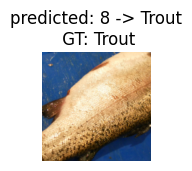

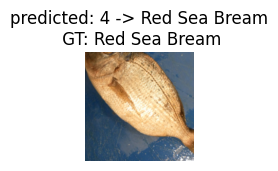

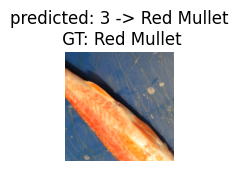

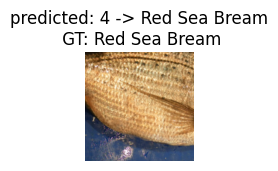

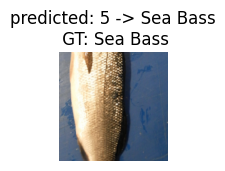

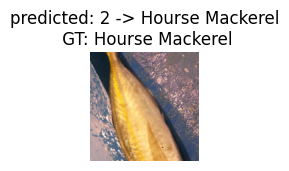

In [10]:
# taking some images from the dataloader and 
# showing the predicted label of our resnet50
# and the ground truth (GT)
visualize_model(model_ft)

Use Tensorboard to make a graph of the model and show how the data flows in the model:

In [11]:
# Grab a single mini-batch of images
dataiter = iter(dataloader_train)
images, labels = next(dataiter)
#move data to GPU
images = images.to(torch.device("cuda"))
labels = labels.to(torch.device("cuda"))

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(model_ft, images)
writer.flush()

In [12]:
#close the writer 
writer.close()